Setup

In [1]:
import sys
assert sys.version_info >= (3, 10)

In [2]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [3]:
if IS_COLAB:
    %pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.0 MB/s eta 0:00:00


In [4]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

## Vamos emitir um aviso caso não haja nenhum acelerador de hardware disponível:

In [6]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

### Definindo os tamanhos de fonte padrão para as figuras

- Assim como nos capítulos anteriores, podemos **ajustar os tamanhos de fonte padrão** para que os gráficos e figuras fiquem mais **legíveis e visualmente agradáveis**.
- Isso não afeta os dados ou o treinamento, apenas melhora a apresentação das visualizações.


In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Reusing Pretrained Layers

- **Ideia principal:**  
  Não é recomendável treinar uma **DNN (Deep Neural Network)** muito grande do zero sem antes verificar se já existe uma rede neural que realiza uma tarefa semelhante à que você deseja.  

- **Vantagens do Transfer Learning:**  
  - Acelera significativamente o treinamento.  
  - Reduz a quantidade de dados necessários para treinar a rede.  

- **Como funciona:**  
  1. Encontre uma DNN já treinada para uma tarefa parecida.  
  2. Reutilize **a maioria das camadas** da rede existente, **exceto as camadas superiores** que são específicas para a tarefa original.  

- **Exemplo prático:**  
  - Suponha que você tenha uma DNN treinada para classificar imagens em **100 categorias** (animais, plantas, veículos, objetos do dia a dia).  
  - Se agora você quer classificar apenas tipos específicos de veículos, essas tarefas são **muito similares**.  
  - Nesse caso, faz sentido **reaproveitar partes da primeira rede**, ajustando apenas as camadas superiores para a nova tarefa.  

> A figura a seguir ilustra como partes de uma rede podem ser reutilizadas para uma tarefa relacionada:
>
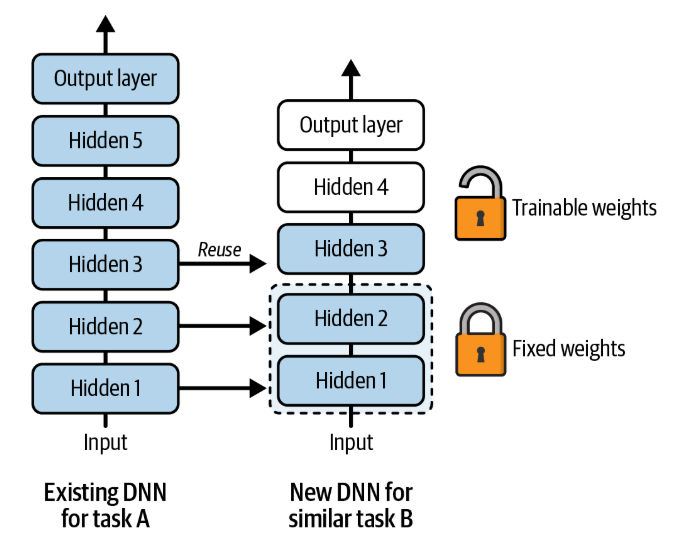


### Ajustando camadas ao usar Transfer Learning

- **Camada de saída (output layer):**  
  - Normalmente deve ser **substituída**, pois os outputs da rede original provavelmente não são úteis para a nova tarefa.  
  - Pode não ter o **número correto de saídas** para o novo problema.

- **Camadas ocultas superiores (upper hidden layers):**  
  - Geralmente são **menos reutilizáveis** que as camadas inferiores.  
  - Os **recursos de alto nível** que são úteis para a nova tarefa podem ser muito diferentes dos recursos aprendidos para a tarefa original.  

- **Estratégia prática para reutilização de camadas:**  
  1. **Congelar as camadas reutilizadas**:  
     - Defina `requires_grad = False` para que os parâmetros dessas camadas **não sejam treináveis**.  
     - Isso mantém os pesos **fixos** durante o treinamento inicial.  
  2. Treine o modelo e avalie o desempenho.  
  3. **Descongele gradualmente** uma ou duas camadas superiores, permitindo que a retropropagação ajuste seus pesos.  
     - Quanto mais dados de treinamento disponíveis, mais camadas podem ser descongeladas.  
     - É recomendado **reduzir a taxa de aprendizado** ao descongelar camadas para não destruir os pesos já ajustados.  

- **Iterando para encontrar o melhor ajuste:**  
  - Se o desempenho ainda for ruim e houver **poucos dados**, tente **remover a(s) camada(s) superior(es)** e congelar novamente as demais.  
  - Se houver **muitos dados**, é possível substituir as camadas superiores e até **adicionar novas camadas ocultas**.  
  - O objetivo é **encontrar o número ideal de camadas a reutilizar** para a nova tarefa.



O Transfer Learning é uma estratégia poderosa para acelerar o treinamento de redes neurais e melhorar a performance, especialmente quando se dispõe de **poucos dados** para a nova tarefa. A chave para seu sucesso está em **reaproveitar camadas** de um modelo pré-treinado, ajustando cuidadosamente:

- **Camadas inferiores** geralmente contêm recursos genéricos e podem ser reutilizadas com segurança.  
- **Camadas superiores** capturam padrões específicos da tarefa original e podem precisar ser adaptadas ou substituídas.  
- O **congelamento inicial das camadas reaproveitadas**, seguido por **fine-tuning gradual**, permite preservar os conhecimentos já adquiridos e adaptar o modelo à nova tarefa de forma eficiente.

Em resumo, Transfer Learning não apenas economiza tempo e dados, mas também permite que redes já treinadas sirvam como **fundamento sólido** para resolver problemas relacionados, tornando o desenvolvimento de modelos mais rápido e robusto.

### Transfer Learning with PyTorch

- **Treinamento dividido em dois conjuntos:**
  - `X_train_A`: todas as imagens de **todos os itens**, exceto **T-shirts/tops** e **pullovers** (classes 0 e 2).  
  - `X_train_B`: um conjunto **muito menor**, contendo apenas as **20 primeiras imagens** de T-shirts/tops e pullovers.

- **Validação e teste:** também são divididos dessa forma, **sem restrição de número de imagens**.

### Estratégia de Treinamento

1. Treinar um **modelo no conjunto A** (classificação com 8 classes).  
2. Reutilizar o modelo treinado para **conjunto B** (classificação binária).

- A ideia é **transferir conhecimento** de A para B, já que as classes de A (trousers, dresses, coats, sandals, shirts, sneakers, bags, ankle boots) são **relativamente similares** às classes de B (T-shirts/tops e pullovers).

### Observação sobre camadas Linear

- Como estamos usando **camadas Lineares**, apenas **padrões que aparecem na mesma posição** podem ser reutilizados.  
- Em contraste, **camadas convolucionais transferem melhor**, pois padrões aprendidos podem ser detectados **em qualquer posição da imagem**.  
- Transfer learning com camadas convolucionais será discutido com mais detalhes no **Capítulo 12**.


Antes de treinar os modelos, precisamos **baixar o dataset Fashion MNIST**, separar os conjuntos de treino, validação e teste, e criar os **DataLoaders** do PyTorch para manipulação eficiente dos dados.

No nosso exemplo:

- **Conjunto A:** todas as imagens exceto T-shirts/tops e pullovers (classes 0 e 2).  
- **Conjunto B:** um conjunto pequeno contendo apenas 20 imagens de T-shirts/tops e pullovers.  
- **Validação e teste:** também são divididos dessa forma, mas sem restrição no número de imagens.

Além disso, ajustamos os labels para:

- Conjunto A: de `[1,3,4,5,6,7,8,9]` para `[0,...,7]`  
- Conjunto B: labels binários (`T-shirt=1`, `Pullover=0`

In [8]:
from torch.utils.data import TensorDataset, DataLoader # Importa classes para criar datasets PyTorch e DataLoaders
from sklearn.datasets import fetch_openml  # Importa função para baixar datasets do OpenML

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False) # Baixa o dataset Fashion MNIST como arrays numpy
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.) # Converte os dados em tensor float e normaliza para [0,1], reshape para (N,1,28,28)
y = torch.from_numpy(fashion_mnist.target.astype(int))  # Converte os labels para tensor inteir
in_B = (y == 0) | (y == 2) # Cria máscara booleana para identificar Pullover (0) e T-shirt/top (2)
X_A, y_A = X[~in_B], y[~in_B] # Seleciona os dados que **não** são Pullover/T-shirt para o conjunto A
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]  # Ajusta labels de A: de [1,3,4,5,6,7,8,9] para [0,...,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)  # Seleciona dados Pullover/T-shirt para B e cria labels binários: T-shirt=1, Pullover=0, formato coluna (-1,1)

# ===================== Criando TensorDatasets =====================

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])  # Conjunto de treino A (todas as imagens exceto últimas 7000)
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])  # Conjunto de validação A (subset das últimas 7000)
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])   # Conjunto de teste A (últimas 5000 imagens)
train_set_B = TensorDataset(X_B[:20], y_B[:20]) # Conjunto de treino B (primeiras 20 imagens)
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000]) # Conjunto de validação B
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:]) # Conjunto de teste B

# ===================== Criando DataLoaders =====================

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True) # DataLoader de treino A com shuffle
valid_loader_A = DataLoader(valid_set_A, batch_size=32)  # DataLoader de validação A
test_loader_A = DataLoader(test_set_A, batch_size=32)  # DataLoader de teste A

train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True) #DataLoader de treino B com shuffle
valid_loader_B = DataLoader(valid_set_B, batch_size=32)  #DataLoader de validação B
test_loader_B = DataLoader(test_set_B, batch_size=32)   #DataLoaderdeteste B


Após criarmos os `TensorDatasets` e `DataLoaders`, estamos prontos para:

1. **Treinar o modelo no Conjunto A** (classificação com 8 classes).  
2. **Reaproveitar esse modelo** para o Conjunto B (classificação binária), aplicando Transfer Learning.  

Alguns pontos importantes:

- Os **DataLoaders** facilitam o treino em mini-batches, economizando memória e acelerando a computação.  
- O **shuffle** nos conjuntos de treino garante que o modelo não aprenda padrões de ordem dos dados.  
- No Conjunto B, o **tamanho muito pequeno do treino** reforça a importância de reutilizar camadas do modelo pré-treinado, evitando overfitting.  



## Funções de avaliação e treinamento

Para treinar e avaliar nossos modelos de forma organizada, definimos duas funções principais:

1. **`evaluate_tm`**  
   - Avalia o desempenho do modelo em um conjunto de dados sem atualizar os pesos.  
   - Utiliza `torch.no_grad()` para economizar memória e acelerar o cálculo.  
   - Atualiza a métrica fornecida (como Accuracy) e retorna o valor final.

2. **`train`**  
   - Treina o modelo por um número definido de épocas (`n_epochs`).  
   - Para cada época, realiza:
     - Forward pass: computa as previsões do modelo.  
     - Cálculo da perda (`loss_fn`) e backpropagation.  
     - Atualização dos pesos do modelo usando o otimizador (`optimizer.step()`).  
     - Atualização das métricas de treino e validação.  
   - Armazena o histórico de perdas e métricas para análise posterior.

Essas funções são genéricas e podem ser usadas tanto para tarefas de **classificação multiclasse** qu

In [9]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()  #Coloca o modelo em modo avaliação (desativa dropout e batchnorm)
    metric.reset()  #Reseta o estado do métrico (ex.: Accuracy)
    with torch.no_grad():  #Desativa cálculo de gradientes (economiza memória e tempo)
        for X_batch, y_batch in data_loader: #Itera sobre batches do DataLoader
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) #Move dados para GPU/CPU
            y_pred = model(X_batch) #Faz a previsão do modelo
            metric.update(y_pred, y_batch)  # Atualiza a métrica com previsões e labels
    return metric.compute() # Retorna o valor final da métrica

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []} # Armazena histórico de treino
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train() # Coloca o modelo em modo treino (ativa dropout e batchnorm)
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)  # Forward pass
            loss = loss_fn(y_pred, y_batch) # Calcula a perda
            total_loss += loss.item()  # Acumula perda para média
            loss.backward()  # Backpropagation
            # Uncomment to activate gradient clipping:
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()    # Atualiza os pesos do modelo
            optimizer.zero_grad() #Zera os gradientes para a próxima iteração
            metric.update(y_pred, y_batch) #Atualiza a métrica de treino
        history["train_losses"].append(total_loss / len(train_loader)) # Média da perda por batch
        history["train_metrics"].append(metric.compute().item())   # Métrica média de treino
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item()) # Avalia métrica no conjunto de validação
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history  # Retorna histórico completo de perdas e métricas

### Observações importantes

- O uso de `model.train()` e `model.eval()` garante que camadas como **dropout** e **batch normalization** se comportem corretamente durante treino e avaliação.  
- O `DataLoader` permite iterar sobre **mini-batches**, tornando o treinamento mais eficiente e estável.  
- Com o histórico retornado (`history`), é possível **plotar curvas de perda e métricas**, monitorando overfitting e desempenho do modelo.  
- Essas funções serão úteis para **comparar modelos pré-treinados**, **modelos novos** e aplicar técnicas de **Transfer Learning**.


### Definindo o Modelo Base (model_A)

Vamos criar um modelo totalmente conectado (dense network) para classificar o conjunto A do Fashion MNIST:

- **Entrada:** imagens de 28x28 pixels (784 elementos após achatar).  
- **Camadas ocultas:** três camadas lineares com 100 neurônios cada, usando ReLU como ativação.  
- **Saída:** 8 neurônios, correspondendo às 8 classes do conjunto A.  
- **Reprodutibilidade:** definimos uma semente (`torch.manual_seed(42)`) para que os resultados possam ser reproduzidos.  
- **Dispositivo:** o modelo é movido para `device` (CPU ou GPU) para acelerar o treinamento.


In [10]:
import torch.nn as nn
torch.manual_seed(42) # Define a semente aleatória para reprodutibilidade

model_A = nn.Sequential(
    nn.Flatten(),    # Achata a imagem 28x28 em um vetor de 784 elementos
    nn.Linear(28 * 28, 100),  # Camada Linear com 784 entradas e 100 neurônios
    nn.ReLU(), # Função de ativação ReLU
    nn.Linear(100, 100),  # Segunda camada Linear, 100 -> 100 neurônios
    nn.ReLU(), # ReLU
    nn.Linear(100, 100),  # Terceira camada Linear, 100 -> 100 neurônios
    nn.ReLU(),  # ReLU
    nn.Linear(100, 8)  # Camada de saída com 8 neurônios (8 classes)
)
model_A = model_A.to(device) # Move o modelo para GPU ou CPU, dependendo do device


### Observações sobre o modelo

- `nn.Sequential` permite empilhar camadas de forma simples, executando-as sequencialmente.  
- `nn.Flatten()` transforma a imagem em vetor para que camadas lineares possam processá-la.  
- Camadas lineares aprendem **combinações ponderadas dos inputs**, enquanto a ReLU introduz **não-linearidade**, permitindo capturar padrões complexos.  
- O número de neurônios e camadas pode ser ajustado dependendo do tamanho do dataset e da complexidade da tarefa.  
- Este modelo servirá como **base para Transfer Learning**, reutilizando camadas treinadas para o conjunto B.


### Inicialização dos Pesos com He (Kaiming)

Para redes totalmente conectadas com ReLU, é importante inicializar os pesos de forma adequada para:

- Evitar que os gradientes desapareçam ou explodam durante o treino.  
- Acelerar a convergência.  

A técnica **He Initialization (Kaiming Normal)** é adequada para funções de ativação ReLU.  
O bias das camadas é normalmente inicializado como zero.

In [11]:
def use_he_init(layer):
    # Verifica se a camada é do tipo Linear (fully connected)
    if isinstance(layer, nn.Linear):
      # Inicializa os pesos usando He Normal (Kaiming) adequado para ReLU
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        # Inicializa os bias com zero, se existirem
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)

# Aplica a função de inicialização em todas as camadas do modelo
model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

### Observações sobre a Inicialização

- `isinstance(layer, nn.Linear)` garante que a inicialização só será aplicada às camadas lineares.  
- `nn.init.kaiming_normal_` distribui os pesos de forma que a variância dos outputs permaneça aproximadamente constante.  
- `nn.init.constant_` define os bias como zero, evitando enviesamento inicial.  
- `model_A.apply(use_he_init)` percorre todas as camadas do modelo, aplicando a função `use_he_init`.  
- Inicializar corretamente os pesos é especialmente importante em redes profundas, mesmo para redes densas como essa.


### Treinamento do Modelo A

Agora que definimos o modelo `model_A` e inicializamos seus pesos, vamos treiná-lo com o conjunto A.

- **Número de épocas (`n_epochs`)**: define quantas vezes o modelo verá todo o conjunto de treino.  
- **Otimizador (`optimizer`)**: Stochastic Gradient Descent (SGD) com learning rate 0.005.  
- **Função de perda (`xentropy`)**: `CrossEntropyLoss` é adequada para problemas de classificação com múltiplas classes.  
- **Métrica (`accuracy`)**: mede a acurácia do modelo para as 8 classes, usando `torchmetrics`.  
- **Treinamento**: chamamos a função `train`, que realiza o loop de treino, calcula perda e métrica no conjunto de treino e validação.


In [12]:
n_epochs = 20 # Número de épocas de treino
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.005)   # Otimizador SGD com learning rate 0.005
xentropy = nn.CrossEntropyLoss()  # Função de perda para classificação multiclass
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy,
                  train_loader_A, valid_loader_A, n_epochs)
# Métrica de acurácia para 8 classes, movida para GPU/CPU

Epoch 1/20, train loss: 0.6123, train metric: 0.8021, valid metric: 0.8350
Epoch 2/20, train loss: 0.3399, train metric: 0.8838, valid metric: 0.8930
Epoch 3/20, train loss: 0.2974, train metric: 0.8975, valid metric: 0.9010
Epoch 4/20, train loss: 0.2742, train metric: 0.9045, valid metric: 0.8210
Epoch 5/20, train loss: 0.2597, train metric: 0.9090, valid metric: 0.8875
Epoch 6/20, train loss: 0.2471, train metric: 0.9132, valid metric: 0.8935
Epoch 7/20, train loss: 0.2361, train metric: 0.9178, valid metric: 0.8900
Epoch 8/20, train loss: 0.2282, train metric: 0.9201, valid metric: 0.9085
Epoch 9/20, train loss: 0.2208, train metric: 0.9227, valid metric: 0.9115
Epoch 10/20, train loss: 0.2126, train metric: 0.9253, valid metric: 0.9025
Epoch 11/20, train loss: 0.2080, train metric: 0.9272, valid metric: 0.9125
Epoch 12/20, train loss: 0.2022, train metric: 0.9287, valid metric: 0.8975
Epoch 13/20, train loss: 0.1980, train metric: 0.9297, valid metric: 0.9185
Epoch 14/20, train lo

### Observações sobre o Treinamento

- O modelo `model_A` agora aprende a classificar as 8 classes do conjunto A.  
- `history_A` armazena o histórico de treino:  
  - `train_losses`: perda média por época no conjunto de treino.  
  - `train_metrics`: acurácia média por época no conjunto de treino.  
  - `valid_metrics`: acurácia média por época no conjunto de validação.  
- Esse histórico permite avaliar o desempenho do modelo ao longo do treino e detectar possíveis problemas como overfitting.

### Definição do Modelo B (Classificação Binária)

Agora vamos criar um modelo `model_B` para a tarefa binária (T-shirt/top vs Pullover), usando a mesma arquitetura do modelo A, mas ajustando a camada de saída para um neurônio.

- **Semente aleatória (`torch.manual_seed(9)`)**: garante reprodutibilidade do modelo.  
- **Camadas Linear e ReLU**: mesmas camadas ocultas que o modelo A, mantendo a capacidade de aprendizado.  
- **Camada de saída**: contém apenas 1 neurônio, pois a tarefa agora é **binária**.  
- **Movendo para device**: o modelo é colocado na GPU ou CPU, conforme o dispositivo disponível.


In [13]:
torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(), # Achata a imagem 28x28 em um vetor de 784 elemento
    nn.Linear(28 * 28, 100), # Primeira camada Linear: 784 -> 100 neurônios
    nn.ReLU(),   # Função de ativação ReLU
    nn.Linear(100, 100), # Segunda camada Linear: 100 -> 100 neurônios
    nn.ReLU(), # ReLU
    nn.Linear(100, 100),  # Terceira camada Linear: 100 -> 100 neurônios
    nn.ReLU(),  # ReLU
    nn.Linear(100, 1) # Camada de saída com 1 neurônio (saída binária)
).to(device)   # Move o modelo para GPU ou CPU

### Definição do Modelo B (Classificação Binária)

Agora vamos criar um modelo `model_B` para a tarefa binária (T-shirt/top vs Pullover), usando a mesma arquitetura do modelo A, mas ajustando a camada de saída para um neurônio.

- **Semente aleatória (`torch.manual_seed(9)`)**: garante reprodutibilidade do modelo.  
- **Camadas Linear e ReLU**: mesmas camadas ocultas que o modelo A, mantendo a capacidade de aprendizado.  
- **Camada de saída**: contém apenas 1 neurônio, pois a tarefa agora é **binária**.  
- **Movendo para device**: o modelo é colocado na GPU ou CPU, conforme o dispositivo disponível.


### Inicialização dos Pesos do Modelo B

Assim como fizemos para `model_A`, é recomendado inicializar os pesos de `model_B` usando a **inicialização He (Kaiming Normal)**, adequada para camadas com ativação ReLU:

- Garantimos que os **pesos não comecem muito pequenos ou grandes**, evitando saturação da ReLU.  
- Os **biases** são inicializados com zero.  
- Isso melhora a **convergência durante o treinamento**, especialmente com redes densas pequenas.


In [14]:
model_B.apply(use_he_init) # Aplica a função definida anteriormente para inicializar pesos

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

### Observações

- Todos os **pesos das camadas lineares** de `model_B` agora foram inicializados com a estratégia He.  
- O modelo está pronto para ser treinado no **conjunto B** com uma função de perda apropriada para classificação binária.  
- Essa etapa ajuda a **evitar problemas de gradiente** nas primeiras épocas de treinamento.


### Treinamento do Modelo B

Agora que o modelo `model_B` está inicializado, vamos treiná-lo no **conjunto B**, que contém apenas as classes T-shirt/top e Pullover:

- **Função de perda:** `BCEWithLogitsLoss`, adequada para **classificação binária**.  
- **Otimizador:** SGD com taxa de aprendizado 0.005.  
- **Métrica:** Acurácia binária usando `torchmetrics.Accuracy`.  
- O modelo será treinado por **20 épocas**.


In [15]:
n_epochs = 20  # Número de épocas de treino
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)   # Otimizador SGD
xentropy = nn.BCEWithLogitsLoss()   # Função de perda para classificação binária
accuracy = torchmetrics.Accuracy(task="binary").to(device) # Métrica de acurácia binária
# Treina o modelo usando a função definida anteriormente
history_B = train(model_B, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.6735, train metric: 0.6000, valid metric: 0.4980
Epoch 2/20, train loss: 0.6411, train metric: 0.6000, valid metric: 0.5022
Epoch 3/20, train loss: 0.6161, train metric: 0.6000, valid metric: 0.5074
Epoch 4/20, train loss: 0.5955, train metric: 0.6000, valid metric: 0.5189
Epoch 5/20, train loss: 0.5774, train metric: 0.6500, valid metric: 0.5384
Epoch 6/20, train loss: 0.5593, train metric: 0.7000, valid metric: 0.5649
Epoch 7/20, train loss: 0.5444, train metric: 0.7000, valid metric: 0.6036
Epoch 8/20, train loss: 0.5311, train metric: 0.7500, valid metric: 0.6390
Epoch 9/20, train loss: 0.5189, train metric: 0.8500, valid metric: 0.6709
Epoch 10/20, train loss: 0.5075, train metric: 0.9000, valid metric: 0.6980
Epoch 11/20, train loss: 0.4974, train metric: 0.9000, valid metric: 0.7215
Epoch 12/20, train loss: 0.4872, train metric: 0.9500, valid metric: 0.7452
Epoch 13/20, train loss: 0.4774, train metric: 0.9500, valid metric: 0.7584
Epoch 14/20, train lo

### Observações sobre o Treinamento

- Como `train_loader_B` contém apenas **20 imagens de treino**, a rede pode **superajustar rapidamente**.  
- A métrica de acurácia e a perda são monitoradas tanto para o **treino** quanto para a **validação**, permitindo avaliar o desempenho.  
- Este treinamento serve como **linha de base** antes de aplicar **Transfer Learning**, que pode melhorar significativamente os resultados para conjuntos pequenos.


### Avaliando o Modelo `model_B` no Conjunto de Teste

### Avaliando o Modelo B no Conjunto de Teste

Após o treino, é importante verificar o desempenho do modelo `model_B` no **conjunto de teste** (`test_loader_B`), que contém imagens de T-shirt/top e Pullover que o modelo **não viu durante o treino**.

- Usaremos a função `evaluate_tm` definida anteriormente para calcular a **acurácia binária**.


In [16]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.8113, device='cuda:0')

### Observações sobre a Avaliação

- A acurácia retornada representa a **proporção de classificações corretas** entre T-shirts/tops e Pullovers.  
- Dado que temos **apenas 20 imagens de treino**, o desempenho pode ser **limitado** e sujeito a variações.  
- Este resultado será útil para **comparar com o modelo usando Transfer Learning**, que deve melhorar a acurácia, aproveitando o conhecimento do modelo A.


### Criando um Modelo B com Transfer Learning

Agora vamos criar `model_B_on_A`, um modelo para a **tarefa B** (classificação binária) **reutilizando as camadas treinadas do modelo A**:

- Usamos `copy.deepcopy` para copiar **todas as camadas ocultas do modelo A**, preservando seus pesos.  
- Substituímos a **camada de saída** para ter apenas 1 neurônio, adequado para **classificação binária**.  
- Essa abordagem é o **ponto central do Transfer Learning**, onde reutilizamos conhecimento de uma tarefa semelhante.


In [17]:
import copy

torch.manual_seed(43) # Define semente para reprodutibilidade
reused_layers = copy.deepcopy(model_A[:-1]) # Copia todas as camadas de model_A, exceto a última (camada de saída)
# Cria um novo modelo para a tarefa B, reutilizando as camadas copiadas
model_B_on_A = nn.Sequential(
    *reused_layers,                 # Todas as camadas intermediárias do modelo A
    nn.Linear(100, 1) # Nova camada de saída para classificação binária (task B)
).to(device) # Move o modelo para GPU ou CPU

### Observações

- `model_B_on_A` agora combina **camadas pré-treinadas do modelo A** com uma **nova camada de saída para a tarefa B**.  
- Inicialmente, a nova camada de saída **tem pesos aleatórios**, então o modelo ainda precisará de treino.  
- No início, podemos **congelar as camadas reutilizadas** para proteger os pesos já aprendidos e treinar apenas a nova camada.


### Descongelando camadas superiores para fine-tuning

Agora vamos **permitir que algumas camadas do modelo B sejam treináveis**:

- Inicialmente, poderíamos ter congelado todas as camadas copiadas de `model_A` para proteger os pesos.  
- Aqui, **descongelamos as camadas superiores** para permitir que o modelo **ajuste pesos** e se adapte à tarefa B.  
- Não descongelamos a primeira camada (`Flatten` + `Linear inicial`) pois geralmente ela captura **padrões de baixo nível** que já são úteis.


In [18]:
for layer in model_B_on_A[2:]: #Percorre todas as camadas, exceto as primeiras (Flatten e Linear inicial)
    for param in layer.parameters():  #Para cada parâmetro da camada
        param.requires_grad = True  #Permite que o gradiente seja calculado e atualizado

### Observações

- Agora o modelo está pronto para **fine-tuning**: a retropropagação irá atualizar os pesos das camadas superiores.  
- Essa estratégia ajuda a **adaptar o conhecimento prévio** da tarefa A à tarefa B, especialmente útil quando temos **poucos dados** para treinar a nova tarefa.


### Treinamento do modelo B com camadas reaproveitadas

Agora vamos **treinar o modelo B usando transfer learning**:

- As camadas intermediárias do modelo A já foram copiadas e parcialmente descongeladas.  
- A camada de saída foi substituída para se adequar à **classificação binária**.  
- Vamos usar **BCEWithLogitsLoss** para a perda e **SGD** como otimizador.  
- Esse treinamento permite **aproveitar o conhecimento prévio** do modelo A e ajustar o modelo à nova tarefa B.


In [20]:
n_epochs = 20 #Número de épocas de treino
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005) #Função de perda para classificação binária
xentropy = nn.BCEWithLogitsLoss() # Métrica de acurácia binária

# Treina o modelo utilizando as camadas reaproveitadas e a nova camada de saída
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.5927, train metric: 0.5000, valid metric: 0.7317
Epoch 2/20, train loss: 0.4728, train metric: 0.7500, valid metric: 0.9022
Epoch 3/20, train loss: 0.4225, train metric: 0.9500, valid metric: 0.9197
Epoch 4/20, train loss: 0.3972, train metric: 1.0000, valid metric: 0.9149
Epoch 5/20, train loss: 0.3803, train metric: 1.0000, valid metric: 0.9122
Epoch 6/20, train loss: 0.3664, train metric: 1.0000, valid metric: 0.9131
Epoch 7/20, train loss: 0.3536, train metric: 1.0000, valid metric: 0.9139
Epoch 8/20, train loss: 0.3416, train metric: 1.0000, valid metric: 0.9161
Epoch 9/20, train loss: 0.3303, train metric: 1.0000, valid metric: 0.9179
Epoch 10/20, train loss: 0.3196, train metric: 1.0000, valid metric: 0.9199
Epoch 11/20, train loss: 0.3095, train metric: 1.0000, valid metric: 0.9217
Epoch 12/20, train loss: 0.2999, train metric: 1.0000, valid metric: 0.9229
Epoch 13/20, train loss: 0.2909, train metric: 1.0000, valid metric: 0.9241
Epoch 14/20, train lo

### Observações

- O modelo agora ajusta os pesos das camadas superiores para **melhor se adaptar** à tarefa B.  
- Ao reaproveitar camadas pré-treinadas, normalmente obtemos **melhor desempenho**, especialmente quando temos **poucos dados** para a nova tarefa.  
- Esse é um exemplo clássico de **fine-tuning em transfer learning**.


### Avaliando o modelo B com Transfer Learning

Após o treinamento com camadas reaproveitadas, é hora de **avaliar o desempenho** do modelo no conjunto de teste B:

- Usaremos a função `evaluate_tm` que calcula a métrica de acurácia.  
- Isso nos permitirá comparar **o ganho de desempenho** ao usar transfer learning em relação ao modelo treinado do zero.


In [ ]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

### Observações finais

- A acurácia obtida geralmente é **maior do que a obtida treinando do zero**.  
- Isso demonstra que o **conhecimento aprendido no conjunto A** foi útil para a nova tarefa B, mesmo com **apenas 20 imagens de treino**.  
- Essa abordagem é especialmente valiosa quando há **poucos dados disponíveis** para a nova tarefa.


## Unsupervised Pretraining


Quando temos **poucos dados rotulados**, treinar uma rede neural do zero é difícil. Existem duas estratégias principais para lidar com isso:

1. **Aprendizado por Transferência (Transfer Learning)**
2. **Pré-treinamento Não Supervisionado (Unsupervised Pretraining)**

### 1. Aprendizado por Transferência

#### Ideia Principal
- Treine uma **primeira rede neural** em uma tarefa para a qual você **tem muitos dados rotulados ou consegue gerar dados facilmente**.
- As camadas iniciais aprendem **detetores de características (features)** gerais, como bordas, formas ou padrões complexos.
- Reutilize essas **camadas inferiores** na sua tarefa real, que possui poucos dados, e treine apenas as camadas finais.

Exemplos Práticos:

#### a) Reconhecimento Facial
- **Problema:** poucas fotos de cada pessoa.
- **Solução:**
  1. Usar um dataset grande e público (ex.: **VGGFace2**) com milhões de fotos.
  2. Treinar a rede para **detectar se duas fotos são da mesma pessoa**.
  3. Reutilizar as camadas iniciais da rede para classificar corretamente com **poucos dados rotulados**.

#### b) Processamento de Linguagem Natural (NLP)
- **Problema:** poucas anotações para a tarefa específica.
- **Solução:**
  1. Usar um **grande corpus de textos** e gerar dados rotulados automaticamente.
     - Exemplo: mascarar palavras em frases e treinar o modelo para adivinhar a palavra ausente.
     - Exemplo: "O que você ___ falando?" → prever "Está" ou "era".
  2. **Fine-tune** o modelo com seus poucos dados rotulados.
  3. Resultado: o modelo já conhece bastante sobre a língua e aprende rapidamente os detalhes da tarefa específica.

## 2. Pré-Treinamento Não Supervisionado

Quando a tarefa é **complexa** e há **poucos dados rotulados**, mas **não existe** um modelo previamente treinado em algo semelhante, ainda há uma saída:

1. **Tente coletar mais rótulos**. Se não for viável…
2. **Aproveite dados não rotulados** (geralmente fáceis e baratos de obter) para fazer **pré-treino não supervisionado**.

### Estratégia típica (autoencoder)

* **Treine um modelo não supervisionado** (ex.: **autoencoder**) usando **muitos exemplos não rotulados** para aprender **representações úteis** nas **camadas inferiores**.
* **Reaproveite as camadas inferiores** do autoencoder (como extrator de características).
* **Adicione uma camada de saída** específica da sua tarefa.
* **Faça fine-tuning supervisionado** usando os **poucos dados rotulados** disponíveis.

> Ideia central: usar **grandes volumes de dados não rotulados** para aprender **boas representações**, e depois **especializar** o modelo com **poucos rótulos**, reduzindo a necessidade de anotação cara.



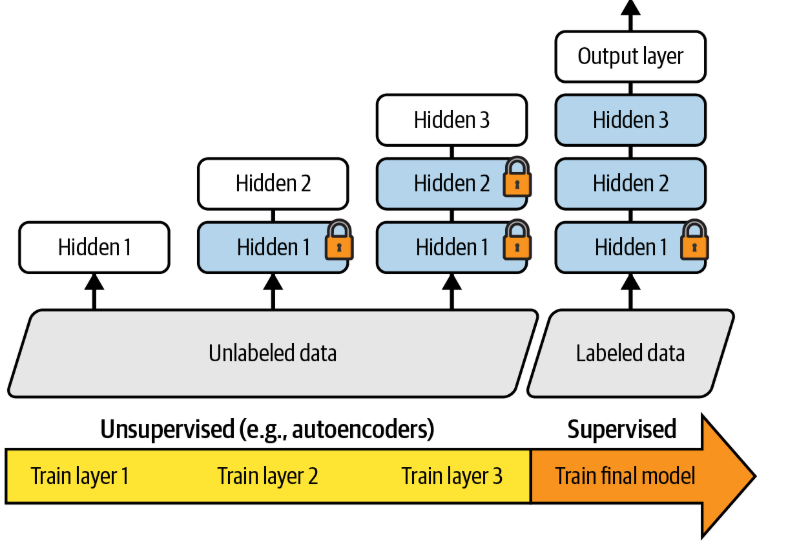


> Esta figura ilustra o **pré-treinamento camada por camada (greedy layer-wise pretraining)**:
> - Cada camada é treinada isoladamente.
> - Depois de treinada, é **congelada**.
> - Em seguida, adiciona-se a próxima camada e repete-se o processo.
> - Método usado nos primeiros anos do deep learning para treinar redes profundas com sucesso.

## 4. História e Contexto

- Essa técnica foi usada por **Geoffrey Hinton e equipe em 2006**, que ajudou a **reviver as redes neurais**. Até 2010, o pré-treinamento não supervisionado com **RBMs (Restricted Boltzmann Machines)** era comum. Hoje, a prática é **mais simples**:
  - Treinar **todas as camadas de uma vez**.
  - Usar modelos modernos como **autoencoders** ou **diffusion models**.
- Continua sendo útil quando:
  - A tarefa é complexa.
  - Não há modelo pré-treinado disponível.
  - Poucos dados rotulados.
  - Muitos dados não rotulados.


## 5. Por que Funciona?

- Camadas iniciais aprendem **padrões gerais**, que são úteis em diversas tarefas.
- Vantagens:
  - Evita treinar do zero.
  - Reduz risco de **overfitting**.
  - Permite bons resultados com **poucos dados rotulados**.

# Pretraining on an Auxiliary Task

Quando você tem **poucos dados rotulados**, treinar uma rede neural do zero pode ser muito difícil ou impossível. Uma alternativa poderosa é **transfer learning**, que consiste em reaproveitar aprendizado de uma rede treinada em outra tarefa.

Como funciona:

1. **Treinar uma rede em uma tarefa auxiliar**
   - Escolha uma tarefa para a qual você tenha muitos dados disponíveis ou possa gerar dados facilmente.
   - Exemplo: detectar se duas fotos mostram a mesma pessoa, ou prever palavras faltantes em textos.

2. **Reutilizar as camadas inferiores**
   - As **camadas iniciais da rede** aprendem padrões gerais, como:
     - Em imagens: bordas, formas, texturas, olhos, nariz, boca.
     - Em textos: relações entre palavras, sintaxe, gramática.
   - Essas camadas podem ser **reaproveitadas na sua tarefa principal**, economizando tempo e dados.

3. **Adicionar e treinar novas camadas superiores**
   - A camada final ou camadas superiores podem ser substituídas para **adaptar a rede à nova tarefa**.
   - Treine apenas essas camadas (ou todas, se houver dados suficientes), usando **taxas de aprendizado menores** para não “destruir” os padrões já aprendidos.

Exemplos práticos:

**Reconhecimento de rostos**
- Problema: poucas fotos por pessoa.
- Solução: treine primeiro uma rede em **milhões de fotos de rostos**, detectando se duas fotos são da mesma pessoa.
- Benefício: a rede aprende detectores de características faciais reutilizáveis para treinar um classificador com poucos dados.

**Processamento de linguagem natural (NLP)**
- Problema: poucos textos rotulados para uma tarefa específica.
- Solução: use um grande corpus de textos e gere **tarefas automáticas de aprendizado**, como:
  - Prever palavras faltantes em frases.
  - Prever a próxima palavra em uma sequência.
- Benefício: o modelo aprende padrões de linguagem geral e pode ser **ajustado (fine-tuning)** para sua tarefa específica.

### Resumo

- Transfer learning permite que modelos aprendam **representações úteis** de uma tarefa auxiliar.
- **Camadas inferiores** aprendem padrões gerais e são reutilizáveis.
- **Camadas superiores** podem ser adaptadas para a tarefa final.
- Estratégia muito útil quando **há poucos dados rotulados**, economizando tempo e melhorando a performance.

# Faster Optimizers

Treinar **redes neurais profundas muito grandes** pode ser **muito lento**. Até agora, vimos quatro maneiras de acelerar o treinamento e alcançar **melhores soluções**:

1. Aplicar uma **boa estratégia de inicialização** dos pesos das conexões.
2. Usar uma **boa função de ativação**.
3. Aplicar **batch normalization (BatchNorm)** ou **layer normalization (LayerNorm)**.
4. Reutilizar partes de uma **rede pré-treinada**, seja de uma tarefa auxiliar ou via aprendizado não supervisionado.


## Otimizadores Rápidos

Além das estratégias acima, um **grande ganho de velocidade** vem do uso de **otimizadores mais rápidos** que o gradiente descendente padrão.  

Nesta seção, serão apresentados os otimizadores mais populares:

- **Momentum**
- **Nesterov Accelerated Gradient (NAG)**
- **AdaGrad**
- **RMSProp**
- **Adam** e suas variantes

In [37]:
# extra code – a little function to test an optimizer on Fashion MNIST

train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000:60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed=42):
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    model.apply(use_he_init)
    return model

def test_optimizer(model, optimizer, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    history = train(model, optimizer, xentropy, accuracy.to(device),
                    train_loader, valid_loader, n_epochs)
    return history, evaluate_tm(model, test_loader, accuracy)

In [38]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
history_sgd, acc_sgd = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5710, train metric: 0.7930, valid metric: 0.8436
Epoch 2/10, train loss: 0.4024, train metric: 0.8530, valid metric: 0.8508
Epoch 3/10, train loss: 0.3620, train metric: 0.8669, valid metric: 0.8692
Epoch 4/10, train loss: 0.3366, train metric: 0.8762, valid metric: 0.8702
Epoch 5/10, train loss: 0.3174, train metric: 0.8831, valid metric: 0.8738
Epoch 6/10, train loss: 0.3030, train metric: 0.8870, valid metric: 0.8712
Epoch 7/10, train loss: 0.2906, train metric: 0.8913, valid metric: 0.8772
Epoch 8/10, train loss: 0.2807, train metric: 0.8957, valid metric: 0.8784
Epoch 9/10, train loss: 0.2715, train metric: 0.8978, valid metric: 0.8786
Epoch 10/10, train loss: 0.2622, train metric: 0.9016, valid metric: 0.8710


## 1. Momentum

Pense em uma bola de boliche descendo uma rampa: ela começa devagar e ganha **ímpeto** ao longo do caminho. O *momentum* faz isso no treinamento: em vez de usar apenas o gradiente instantâneo, ele acumula um **vetor de momento** que “empurra” os pesos na **direção média** dos gradientes recentes, acelerando quando a inclinação persiste e suavizando oscilações. Em regiões de vale alongado (escalas muito diferentes nas entradas), isso ajuda a “rolar” pelo vale cada vez mais rápido, enquanto o gradiente descendente puro tende a ser lento e serrilhado.

**Gradiente descendente clássico:**
$$
\boldsymbol${\theta}$ \leftarrow \boldsymbol${\theta}$ - \eta,\nabla_${\boldsymbol${\theta}$}$ J(\boldsymbol${\theta}$)
$$

**Momentum (com vetor de momento $(\mathbf{m}))$:**
$$
\mathbf{m} \leftarrow \beta,\mathbf{m} - \eta,\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})
$$
$$
\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \mathbf{m}
$$

Aqui, $(\eta)$ é a **taxa de aprendizado** e $(0 \le \beta < 1)$ é o **coeficiente de momentum** (típico: $(\beta = 0{,}9))$. A leitura física é útil: o gradiente atua como **força** que gera **aceleração** (o momento), não como velocidade direta.

**“Velocidade terminal” (gradiente constante, intuição de ganho):**
$$
\text{tamanho máximo da atualização} ;\approx; \frac{\eta}{1-\beta},\bigl|\nabla J\bigr|
$$

Com $(\beta = 0{,}9)$, o fator $(\tfrac{1}{1-0{,}9} = 10)$ explica por que o momentum pode avançar **muito mais rápido** do que o GD puro em inclinações suaves (na prática, o ganho varia porque os gradientes mudam ao longo do treino). Em DNNs sem *batch norm*/*layer norm*, onde camadas superiores recebem entradas com **escalas distintas**, o momentum costuma estabilizar e acelerar bem a convergência — e ainda pode ultrapassar **ótimos locais rasos** graças ao ímpeto acumulado.

**Como usar no PyTorch (direto e prático):**

In [39]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.05)
history_momentum, acc_momentum = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6026, train metric: 0.7829, valid metric: 0.7866
Epoch 2/10, train loss: 0.4777, train metric: 0.8300, valid metric: 0.8430
Epoch 3/10, train loss: 0.4487, train metric: 0.8408, valid metric: 0.8334
Epoch 4/10, train loss: 0.4336, train metric: 0.8457, valid metric: 0.8458
Epoch 5/10, train loss: 0.4053, train metric: 0.8559, valid metric: 0.8426
Epoch 6/10, train loss: 0.3997, train metric: 0.8572, valid metric: 0.8604
Epoch 7/10, train loss: 0.3934, train metric: 0.8586, valid metric: 0.8442
Epoch 8/10, train loss: 0.3789, train metric: 0.8647, valid metric: 0.8556
Epoch 9/10, train loss: 0.3758, train metric: 0.8662, valid metric: 0.8598
Epoch 10/10, train loss: 0.3676, train metric: 0.8689, valid metric: 0.8582


Regra de bolso: escolha um `lr` razoável e $(\beta)$ alto (p.ex., $(0{,}8)–(0{,}99))$; valores de $(\beta)$ maiores preservam mais histórico e podem pedir `lr` um pouco menor.

>A principal desvantagem do *momentum* é **introduzir mais um hiperparâmetro** para ajustar. Na prática, porém, usar **$\beta = 0{,}9$** costuma funcionar muito bem **sem tuning exaustivo** e quase sempre resulta em **treino mais rápido** do que o gradiente descendente padrão. Em outras palavras, o ganho de velocidade e estabilidade normalmente **compensa** o custo de ter um parâmetro extra.


### Após o treinamento

- **`model`**: contém a rede neural pronta para **inferência**.  
- **`optimizer`**: controla como os pesos são atualizados, utilizando **gradiente descendente com momentum**.  
- **`history_momentum`**: registra o **histórico do treinamento**, incluindo perdas e métricas por época.  
- **`acc_momentum`**: mostra a **acurácia final do modelo** no conjunto de teste.  

**Resumo:** este trecho de código **constrói, treina e avalia** o modelo usando um **otimizador com momentum**, melhorando a convergência durante o treinamento.




## 2. Nesterov Accelerated Gradient

*momentum* “olhando à frente”

O NAG (Nesterov, 1983) é uma variação do **momentum** que quase sempre **converge mais rápido**. A ideia é **medir o gradiente não em $\boldsymbol{\theta}$**, mas **um passo à frente na direção do momentum**, em $\boldsymbol{\theta} + \beta \mathbf{m}$. Como o vetor de momento costuma apontar na direção do ótimo, esse gradiente “adiantado” é **mais informativo** do que o gradiente local.

**Atualização do NAG (forma prática):**
$$
\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_{\mathbf{\theta}} \mathbf{J}(\mathbf{\theta} + \beta \mathbf{m})
$$

$$
\mathbf{\theta} \gets \mathbf{\theta} + \mathbf{m}
$$

onde:

- $\mathbf{J}(\mathbf{\theta})$ = função de custo que queremos minimizar  
- $\mathbf{\theta}$ = vetor de **parâmetros atuais** da rede  
- $\eta$ = **taxa de aprendizado** (learning rate)  
- $\mathbf{m}$ = **momentum acumulado** até a iteração atual  
- $\beta$ = **coeficiente de momentum**, que controla **quanto do momentum anterior será mantido**

No **momentum clássico**, o gradiente é calculado em $\boldsymbol{\theta}$; no **NAG**, calculamos em $\boldsymbol{\theta} + \beta \mathbf{m}$. Geometricamente, isso coloca a atualização **mais perto do ótimo** a cada iteração. Além disso, quando o momentum “atravessa um vale”, o gradiente local $\nabla_1$ (medido antes do passo) tende a empurrar **para fora** do vale, enquanto o gradiente “olhando à frente” $\nabla_2$ (em $\boldsymbol{\theta} + \beta \mathbf{m}$) **aponta de volta** para o fundo do vale, **reduzindo oscilações** e acelerando a convergência.


**Essência:** o NAG **antecipa** a direção do movimento e **corrige** o passo com um gradiente mais relevante, normalmente resultando em **passos menores na direção errada**, **menos ziguezague** e **convergência mais rápida** do que o momentum padrão.

![foto](image.png)

- **∇1** = gradiente no ponto atual \(\theta_t\)  
- **∇2** = gradiente no ponto previsto \(\theta_t + \beta m_t\)  

#### Noutras palavras:

Pense num ciclista descendo um vale sinuoso visto de cima. As **faixas laranja** são as curvas de nível: quanto **mais claro**, mais **perto do fundo do vale** (menor custo). O ponto “Starting point” é onde o ciclista está agora. Ele já vem com **ímpeto** (momentum), indicado pela **seta preta** ( \beta \mathbf{m} ): é a tendência de continuar naquela direção.

* **Momentum “clássico” (azul):** ele mede a inclinação **exatamente onde está** $((\nabla_1))$. É como olhar só para o chão sob a roda e pedalar seguindo aquela seta. Resultado: o passo azul $(−η∇₁)$ muitas vezes **passa de lado** pelo vale e fica **mais longe** do fundo, porque a inclinação naquele ponto ainda “puxa” na direção errada.

* **Nesterov (verde):** antes de decidir para onde ir, o ciclista **projeta onde estará um instante à frente** se continuar com o ímpeto (vai até $( \theta + \beta \mathbf{m} )$) e **mede a inclinação lá** $((\nabla_2))$. É como **levantar a cabeça** e olhar alguns metros adiante. Essa inclinação já “vê” melhor o **formato do vale** e aponta **mais para o centro**. O passo verde (−η∇₂) termina **mais perto do ótimo** e com **menos zigue-zague**.

Moral da história: o Nesterov **olha à frente na direção do seu próprio momentum** antes de medir o gradiente. Isso corrige o rumo cedo, **reduz oscilações** nas bordas do vale e costuma **chegar mais rápido** ao fundo do que o momentum que só olha o ponto atual.


**Como usar no PyTorch:**

In [40]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(),
                            momentum=0.9, nesterov=True, lr=0.05)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5486, train metric: 0.8048, valid metric: 0.8118
Epoch 2/10, train loss: 0.4340, train metric: 0.8454, valid metric: 0.8336
Epoch 3/10, train loss: 0.4070, train metric: 0.8564, valid metric: 0.8490
Epoch 4/10, train loss: 0.3842, train metric: 0.8629, valid metric: 0.8656
Epoch 5/10, train loss: 0.3756, train metric: 0.8661, valid metric: 0.8528
Epoch 6/10, train loss: 0.3681, train metric: 0.8690, valid metric: 0.8604
Epoch 7/10, train loss: 0.3570, train metric: 0.8733, valid metric: 0.8580
Epoch 8/10, train loss: 0.3524, train metric: 0.8752, valid metric: 0.8538
Epoch 9/10, train loss: 0.3428, train metric: 0.8764, valid metric: 0.8612
Epoch 10/10, train loss: 0.3372, train metric: 0.8799, valid metric: 0.8566


## 3. AdaGrad

![foto](imagens\image.png)


O **AdaGrad** adapta dinamicamente a **taxa de aprendizado por parâmetro**, reduzindo o passo nas direções com gradientes historicamente grandes e permitindo passos relativamente maiores onde os gradientes são pequenos e esparsos. A mecânica é simples: a cada iteração, acumula-se o quadrado do gradiente em um vetor estado:

$$
\mathbf{s} \leftarrow \mathbf{s} + \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) \otimes \nabla_{\mathbf{\theta}} J(\mathbf{\theta})
$$

 onde $\otimes$ indica multiplicação elemento a elemento. Em seguida, os parâmetros são atualizados com um reescalonamento coordenada-a-coordenada do gradiente:

$$
\mathbf{\theta} \leftarrow \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) \oslash \sqrt{\mathbf{s} + \varepsilon}
$$
  
  com $\oslash$ denotando divisão elemento a elemento e $\varepsilon$ (e.g., $10^{-10}$) prevenindo divisão por zero. Em termos intuitivos, o acumulador $s_i=\sum_t\bigl(\partial J/\partial\theta_i\bigr)^2$ funciona como um “freio adaptativo”: se uma componente $\theta_i$ recebe gradientes grandes repetidamente, $s_i$ cresce e o passo efetivo $\eta/\sqrt{s_i+\varepsilon}$ diminui; se a componente quase não recebe sinal (cenário comum em dados esparsos), $s_i$ permanece pequeno e o algoritmo mantém passos mais agressivos nessa direção. Assim, o método tende a **suavizar oscilações** em vales inclinados e a **acelerar a convergência** nas dimensões mais “calmas”, frequentemente reduzindo a necessidade de um ajuste fino de $\eta$ em comparação ao gradiente descendente clássico.

Do ponto de vista prático, essa normalização por histórico torna o AdaGrad especialmente atrativo em tarefas com **features esparsas** (por exemplo, NLP com representações de alta dimensão), pois confere maior passo às coordenadas raramente ativas e controla automaticamente aquelas hiperativas. Em contrapartida, como $\mathbf{s}$ **só cresce** (não há “esquecimento”), a taxa efetiva por parâmetro pode **despencar ao longo do treinamento**, levando a passos excessivamente pequenos e estagnação antes de atingir regiões melhores do ótimo — motivo pelo qual variantes com amortecimento do histórico (p.ex., **RMSProp** ou **Adam**) são hoje preferidas em redes profundas. Ainda assim, quando o relevo é bem condicionado ou quando a esparsidade domina, o AdaGrad permanece um baseline sólido, simples de implementar e com bom comportamento de convergência sem exigir grande engenharia de hiperparâmetros.


#### Noutras palavras:

imagina que você está andando de bicicleta por uma cidade desconhecida fazendo entregas. No início, você não sabe quais ruas são esburacadas (gradientes grandes e frequentes) e quais são lisinhas e raras de aparecer (gradientes pequenos e esparsos). A sua bike tem um sistema de “freios inteligentes” por roda (um para cada parâmetro). Toda vez que você passa por uma rua e leva um tranco, o freio daquela roda fica um pouquinho mais sensível dali pra frente. Ou seja: nas ruas onde você já levou muito tranco, o freio passa a segurar mais — você reduz a velocidade e deixa de dar “passos” grandes ali. Já nas ruas por onde você quase não passa (ou são suaves), o freio mal atua, então você pode seguir mais solto e cobrir terreno mais rápido.

com o tempo, esse sistema vai construindo um **histórico de trancos por rua**: onde o terreno treme muito, você automaticamente anda devagar (passo efetivo menor); onde quase não treme, você anda mais rápido (passo efetivo maior). isso evita zig-zags perigosos nas ladeiras esburacadas (coordenadas com muitos gradientes) e ajuda você a avançar mais onde faltava coragem (coordenadas esparsas). a desvantagem? esses freios só “apertam” cada vez mais — não desapertam sozinhos. depois de muitas entregas, você pode acabar dirigindo devagar demais em quase todo lugar, mesmo quando a rua ficou tranquila, e o progresso fica lento. por isso versões modernas (tipo RMSProp/Adam) colocam um “esquecimento” no freio, para que ele relaxe aos poucos se os trancos pararem.

resumo em 1 linha: **AdaGrad é como freios adaptativos por rua: quanto mais uma rua já te chacoalhou, mais o freio segura naquela direção; ruas pouco usadas ficam com o freio solto, e você acelera nelas.**

In [41]:
model = build_model()  # extra code
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5605, train metric: 0.8155, valid metric: 0.8612
Epoch 2/10, train loss: 0.3699, train metric: 0.8642, valid metric: 0.8678
Epoch 3/10, train loss: 0.3351, train metric: 0.8762, valid metric: 0.8742
Epoch 4/10, train loss: 0.3142, train metric: 0.8835, valid metric: 0.8788
Epoch 5/10, train loss: 0.2982, train metric: 0.8888, valid metric: 0.8802
Epoch 6/10, train loss: 0.2865, train metric: 0.8928, valid metric: 0.8788
Epoch 7/10, train loss: 0.2745, train metric: 0.8973, valid metric: 0.8816
Epoch 8/10, train loss: 0.2663, train metric: 0.9001, valid metric: 0.8802
Epoch 9/10, train loss: 0.2582, train metric: 0.9036, valid metric: 0.8864
Epoch 10/10, train loss: 0.2511, train metric: 0.9060, valid metric: 0.8864


## 3. RMSprop

AdaGrad pode “travar” porque soma **todos** os gradientes ao longo do tempo, encolhendo demais o passo efetivo. O **RMSProp** corrige isso mantendo só uma **memória decrescente** (média móvel exponencial) dos gradientes **recentes**, o que evita a desaceleração irreversível e adapta o passo por coordenada.

Definições básicas:

$$g_t = \nabla_{\theta} J(\theta_t)$$

Acúmulo com decaimento exponencial (variância recente por coordenada):

$$s_t = \alpha, s_{t-1} + (1-\alpha), g_t^2$$

Atualização dos parâmetros com normalização por raiz de $s_t$:

$$\theta_{t+1} = \theta_t - \eta, \dfrac{g_t}{\sqrt{s_t + \varepsilon}}$$

Passo efetivo por coordenada (intuição):

$$\eta_{\text{eff},t} = \dfrac{\eta}{\sqrt{s_t + \varepsilon}}$$

Parâmetros típicos:

$$\alpha \in (0,1)\ \ \text{(geralmente } \alpha = 0.9\text{)}$$

$$\varepsilon \approx 10^{-8}$$

Intuição: se uma coordenada tem gradientes recentes grandes, $s_t$ cresce e o passo nessa direção diminui; se os gradientes ficam pequenos, o passo aumenta relativamente. Isso costuma funcionar melhor que AdaGrad em problemas reais. Historicamente, o RMSProp foi muito usado até o **Adam**, que passou a combinar estimativas do **1º momento** (média dos gradientes) e do **2º momento** (média dos quadrados).

Exemplo em PyTorch (não é fórmula):


In [42]:
model = build_model()  # extra code
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.9, lr=0.05)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 3.0856, train metric: 0.4135, valid metric: 0.4846
Epoch 2/10, train loss: 1.5592, train metric: 0.4054, valid metric: 0.3360
Epoch 3/10, train loss: 1.5156, train metric: 0.4150, valid metric: 0.4274
Epoch 4/10, train loss: 1.4835, train metric: 0.4209, valid metric: 0.4244
Epoch 5/10, train loss: 1.5939, train metric: 0.3872, valid metric: 0.4278
Epoch 6/10, train loss: 1.5009, train metric: 0.4204, valid metric: 0.4074
Epoch 7/10, train loss: 1.5294, train metric: 0.3967, valid metric: 0.3342
Epoch 8/10, train loss: 1.7418, train metric: 0.3270, valid metric: 0.2402
Epoch 9/10, train loss: 1.6990, train metric: 0.3328, valid metric: 0.2942
Epoch 10/10, train loss: 1.7721, train metric: 0.3072, valid metric: 0.2708


#### Noutras Palavras:

Aqui vai uma analogia simples para **RMSProp**:

Pense que você está correndo por uma trilha cheia de pedras no escuro com uma lanterna na cabeça.

* **AdaGrad** é como usar uma lanterna que vai **apagando para sempre** quanto mais tempo você corre. No começo você enxerga bem, mas como ela só acumula “cansaço” (soma todos os choques do passado), a luz vai ficando cada vez mais fraca até você quase não conseguir ajustar o passo — e pode nunca chegar ao final com segurança.

* **RMSProp** é como usar uma lanterna com **bateria inteligente** que considera **apenas os últimos metros** percorridos para decidir quanta luz precisa agora. Se nos últimos segundos você enfrentou muitos buracos (gradientes grandes recentes), a lanterna desce um pouco a intensidade para você **andar com mais cautela** (passo menor). Se a trilha ficou lisa nos últimos segundos (gradientes pequenos recentes), ela **aumenta a luz** e você pode acelerar (passo maior). Assim, você **não fica preso ao cansaço acumulado de horas atrás** — só ao que realmente importa **agora**.

Em outras palavras: RMSProp é uma “**memória de curto prazo com esquecimento exponencial**” que ajusta seu passo com base no **terreno recente**, evitando que a velocidade caia irreversivelmente como acontece com o AdaGrad.

## 4. Adam (Adaptive Moment Estimation)

Adam (**Adaptive Moment Estimation**) combina **Momentum** e **RMSProp**: ele mantém médias exponencialmente decrescentes tanto dos **gradientes** (1º momento — média) quanto dos **gradientes ao quadrado** (2º momento — variância não centralizada). Em cada iteração $t$, calculamos o gradiente $g_t$ da perda em relação aos parâmetros atuais $\theta_t$, depois atualizamos estimativas de momentos, corrigimos o viés de inicialização e, por fim, atualizamos os parâmetros com um passo adaptativo.

$$g_t = \nabla_{\theta},\mathcal{L}(\theta_t)$$

**Acúmulo do 1º momento (média dos gradientes):**

$$m_t = \beta_1, m_{t-1} + (1-\beta_1), g_t$$

**Acúmulo do 2º momento (média dos gradientes ao quadrado):**

$$v_t = \beta_2, v_{t-1} + (1-\beta_2), g_t^2$$

Como $m_0 = 0$ e $v_0 = 0$, há viés no início. Corrigimos com:

$$\hat{m}_t = \dfrac{m_t}{1-\beta_1^{,t}} \quad\text{e}\quad \hat{v}_t = \dfrac{v_t}{1-\beta_2^{,t}}$$

**Atualização dos parâmetros com passo adaptativo:**

$$\theta_{t+1} = \theta_t - \eta ,\dfrac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}$$

Na prática, usa-se tipicamente $\beta_1 = 0{,}9$, $\beta_2 = 0{,}999$, $\varepsilon = 10^{-8}$, e a taxa de aprendizado padrão é $\eta = 0{,}001$. Por ser adaptativo (como AdaGrad e RMSProp), o Adam costuma exigir **menos ajuste fino** de $\eta$ e funciona bem como **default** em muitos problemas.

No PyTorch, por exemplo:

In [43]:
model = build_model()  # extra code
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adam, acc_adam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.4496, train metric: 0.4273, valid metric: 0.4526
Epoch 2/10, train loss: 1.4728, train metric: 0.3854, valid metric: 0.3730
Epoch 3/10, train loss: 1.5609, train metric: 0.3434, valid metric: 0.2696
Epoch 4/10, train loss: 1.6008, train metric: 0.3061, valid metric: 0.3220
Epoch 5/10, train loss: 1.5894, train metric: 0.3120, valid metric: 0.3034
Epoch 6/10, train loss: 1.5993, train metric: 0.3094, valid metric: 0.2750
Epoch 7/10, train loss: 1.6083, train metric: 0.3085, valid metric: 0.3202
Epoch 8/10, train loss: 1.5974, train metric: 0.3136, valid metric: 0.3124
Epoch 9/10, train loss: 1.5901, train metric: 0.3151, valid metric: 0.3078
Epoch 10/10, train loss: 1.6109, train metric: 0.3166, valid metric: 0.2960


#### Noutras palavras:

Imagine que você está andando de bicicleta por um terreno irregular:

* O **Momentum** é como ter **inércia**: você suaviza oscilações e mantém direção média do movimento recente (primeiro momento).
* O **RMSProp** é como ajustar a **suspensão** conforme a **rugosidade recente** do solo (segundo momento), reduzindo o passo onde o terreno “sacode” muito.
* O **Adam** junta as duas coisas ao mesmo tempo: **inércia inteligente** (primeiro momento) + **suspensão adaptativa** (segundo momento) com uma **correção de início** para não sair enviesado quando você começa a pedalar.

### Variantes do Adam (em uma linha cada)

* **AdaMax**: versão do Adam com norma $\ell_\infty$, mais estável quando há gradientes muito grandes e esparsos.
* **NAdam**: Adam com **Nesterov momentum**, antecipa a direção e pode acelerar a convergência em alguns cenários.
* **AdamW**: separa corretamente o **weight decay** da atualização (em vez de via L2 na perda), melhorando regularização em arquiteturas modernas.


## 5. AdaMax

O **AdaMax** é uma variação do **Adam**, proposta no mesmo artigo original de *Kingma e Ba (2015)*.  
A ideia é simples: tornar o Adam **ainda mais estável**, especialmente quando os **gradientes são muito grandes** ou apresentam **valores extremos**.

O Adam usa a **norma $\ell_2$** (ou seja, a raiz da soma dos quadrados dos gradientes) para ajustar o tamanho dos passos de atualização.  
Mas o AdaMax muda essa regra: ele usa a **norma $\ell_\infty$** — que basicamente pega o **maior valor absoluto** dos gradientes recentes.

 Em outras palavras:
- O AdaMax **observa o maior gradiente** entre todos os parâmetros,  
- e usa esse valor para **controlar a atualização** de forma mais robusta.

Isso faz com que ele **tolere gradientes explosivos** e seja **menos sensível a picos repentinos** no treinamento.


## Diferença entre Adam e AdaMax

| Característica | **Adam** | **AdaMax** |
|-----------------|-----------|-------------|
| Tipo de norma usada | $\ell_2$ → soma dos quadrados | $\ell_\infty$ → máximo absoluto |
| Correção de viés | Corrige $m$ e $s$ | Corrige apenas $m$ |
| Sensibilidade a grandes gradientes | Média | **Baixa (mais estável)** |
| Desempenho prático | Muito bom | **Mais estável em casos extremos** |

##  Equações do AdaMax

1. **Atualização do primeiro momento (média dos gradientes):**

   $$
   m \leftarrow \beta_1 m + (1 - \beta_1)\nabla_\theta J(\theta)
   $$

   - Aqui  $m$ representa a **tendência média dos gradientes** (como no Momentum).

2. **Atualização do segundo momento (usando norma \(\ell_\infty\)):**

   $$
   s \leftarrow \max(\beta_2 s,\, |\nabla_\theta J(\theta)|)
   $$

   - Em vez de usar quadrados dos gradientes, o AdaMax usa o **maior valor absoluto** dos gradientes decaídos no tempo.

3. **Atualização dos parâmetros:**

   $$
   \theta \leftarrow \theta - \frac{\eta}{s} \, m
   $$

   - A divisão é feita **elemento a elemento**, e \( s \) serve como uma escala que limita o tamanho do passo.

##  Significado dos Parâmetros

- **$\beta_1$** → controla o quanto o algoritmo “lembra” dos gradientes passados (geralmente **0.9**).  
- **$\beta_2$** → controla o quanto o algoritmo “lembra” dos gradientes máximos (geralmente **0.999**).  
- **$\eta$** → taxa de aprendizado, normalmente **0.002**.  
- **$s$** → mantém o **maior gradiente observado recentemente**.  
- **$m$** → mantém a **média móvel dos gradientes**.

#### Noutras Palavras:

* **Adam** ajusta a velocidade olhando a **média da “força” dos solavancos recentes** (algo como um “RMS” dos impactos): se, em geral, o piso está mais áspero, você reduz; se está mais liso, acelera um pouco.

* **AdaMax** dirige com outra regra: ele pergunta apenas **“qual foi o pior tranco recente?”** e regula a velocidade **pelo maior solavanco** que apareceu no caminho (o “máximo” absoluto). Assim, mesmo que a estrada esteja quase lisa, se surgiu um buracão isolado, o jipe entra em **modo cautela** e não deixa você acelerar além do que aquele pior buraco permitiria.

Em outras palavras: Adam suaviza pelo “tamanho médio” dos trancos; AdaMax coloca um **limite rígido baseado no pior tranco** observado recentemente. Isso pode deixá-lo mais estável quando aparecem impactos esporádicos e enormes (outliers), porque ele passa a dirigir “pelo pior caso” em vez da média.


In [44]:
model = build_model()  # extra code
optimizer = torch.optim.Adamax(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adamax, acc_adamax = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6799, train metric: 0.7774, valid metric: 0.7860
Epoch 2/10, train loss: 0.5126, train metric: 0.8211, valid metric: 0.8344
Epoch 3/10, train loss: 0.4768, train metric: 0.8340, valid metric: 0.8314
Epoch 4/10, train loss: 0.4550, train metric: 0.8395, valid metric: 0.8346
Epoch 5/10, train loss: 0.4363, train metric: 0.8462, valid metric: 0.8404
Epoch 6/10, train loss: 0.4283, train metric: 0.8491, valid metric: 0.8492
Epoch 7/10, train loss: 0.4228, train metric: 0.8508, valid metric: 0.8342
Epoch 8/10, train loss: 0.4126, train metric: 0.8555, valid metric: 0.8402
Epoch 9/10, train loss: 0.4131, train metric: 0.8538, valid metric: 0.8366
Epoch 10/10, train loss: 0.4032, train metric: 0.8580, valid metric: 0.8546


## 6. Nadam

O **NAdam (Nesterov-accelerated Adaptive Moment Estimation)** é uma variação do **Adam** que incorpora o conceito de **Nesterov Momentum**.  
Em resumo, ele combina o **Adam** com o **“empurrão antecipado”** do **Nesterov**, resultando em atualizações mais ágeis e, muitas vezes, **convergência mais rápida**.

Antes de entender o NAdam, vale lembrar:

- O **Momentum** aplica uma média móvel aos gradientes, ajudando a suavizar o caminho até o mínimo.  
- O **Nesterov Momentum** vai além: ele **olha um passo à frente**, calculando o gradiente **após** uma atualização provisória — isso antecipa a direção do próximo movimento.  
- O **Adam** combina o Momentum com o ajuste **adaptativo da taxa de aprendizado** (como o RMSProp).

👉 O **NAdam** mistura esses dois mundos:  
usa a **inteligência adaptativa do Adam**, mas com a **antecipação do Nesterov**, tornando o movimento mais eficiente e menos oscilatório.

A atualização do NAdam pode ser vista como uma versão “prevenida” do Adam:

$$
\theta \leftarrow \theta - \eta \frac{ \beta_1 \hat{m}_{t-1} + (1 - \beta_1)\nabla_\theta J(\theta_t) / (1 - \beta_1^t) }{ \sqrt{\hat{s}_t} + \varepsilon }
$$

Onde:
- $\hat{m}_t$ e $\hat{s}_t$ são as versões **corrigidas pelo viés** da média e variância dos gradientes (como no Adam).  
- O termo adicional **$\beta_1 \hat{m}_{t-1}$** vem do **Nesterov**, que antecipa o movimento.

## Passo a Passo Conceitual

1. **Mantém o histórico dos gradientes passados**, como o Adam.  
2. **Aplica uma previsão de movimento (Nesterov)**, avaliando o gradiente “um passo à frente”.  
3. **Ajusta o tamanho do passo** usando o histórico de gradientes (taxa adaptativa).  
4. **Atualiza os parâmetros** com um passo mais rápido e mais suave.

##  Por que usar o NAdam?

- Pode oferecer **convergência mais rápida** em muitos problemas práticos.  
- Reduz **oscilações** e melhora a **estabilidade** da otimização.  
- Mantém o mesmo número de **hiperparâmetros** do Adam — não adiciona complexidade.  

##  Detalhes Importantes

- Foi introduzido por **Timothy Dozat (2016)** em um relatório comparando otimizadores.  
- O desempenho depende do **dataset** e da **arquitetura da rede**.  
  → Em algumas tarefas, **RMSProp** ainda pode superar o NAdam.  
- Os valores típicos dos hiperparâmetros são os mesmos do Adam:  
  $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\eta = 0.001$.

##  Dica Prática

> Se o **Adam** está funcionando bem, o **NAdam** pode ser um **passo natural para tentar melhorar a velocidade de convergência**, especialmente em redes profundas com gradientes ruidosos.

##  Em resumo

| Conceito | Descrição |
|-----------|------------|
| **Baseado em** | Adam + Nesterov Momentum |
| **Vantagem principal** | Convergência mais rápida e suave |
| **Custo adicional** | Nenhum (mesmos hiperparâmetros) |
| **Uso recomendado** | Quando o Adam é estável, mas lento |


#### Noutras Palavras:
Pense em **andar de bicicleta com vento a favor (momentum) e olhar a curva antes de entrar (Nesterov)**.

* No **Adam**, você pedala com impulso acumulado e regula a força conforme a “rugosidade média” recente do piso (RMSProp), ajustando a cadência de forma adaptativa.
* No **NAdam**, além disso, você **projeta um passinho à frente**: antes de aplicar a pedalada final, você dá uma espiada no terreno logo adiante (o “lookahead” de Nesterov). Se vê que está prestes a entrar numa subida/curva, já **corrige a direção e a força** antecipadamente; se percebe um trecho mais liso, **aproveita melhor o embalo**.

Resultado: o NAdam costuma **reagir mais rápido e com menos oscilação** do que o Adam, porque **ajusta o passo com base no futuro imediato**, não apenas no passado recente—o que frequentemente encurta o caminho até o ponto ótimo.



In [45]:
model = build_model()  # extra code
optimizer = torch.optim.NAdam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_nadam, acc_nadam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 2.2631, train metric: 0.1478, valid metric: 0.1046
Epoch 2/10, train loss: 2.3083, train metric: 0.1001, valid metric: 0.0936
Epoch 3/10, train loss: 2.3078, train metric: 0.1013, valid metric: 0.1056
Epoch 4/10, train loss: 2.3082, train metric: 0.1011, valid metric: 0.0936
Epoch 5/10, train loss: 2.3080, train metric: 0.1010, valid metric: 0.0982
Epoch 6/10, train loss: 2.3081, train metric: 0.0988, valid metric: 0.1018
Epoch 7/10, train loss: 2.3096, train metric: 0.0987, valid metric: 0.1014
Epoch 8/10, train loss: 2.3039, train metric: 0.1033, valid metric: 0.0980
Epoch 9/10, train loss: 2.3086, train metric: 0.1017, valid metric: 0.0994
Epoch 10/10, train loss: 2.3088, train metric: 0.0985, valid metric: 0.1042


## AdamW (Adam with Weight Decay)

O **AdamW** (*Adam with Weight Decay*) é uma variação aprimorada do **Adam** que incorpora de forma **correta** a técnica de regularização conhecida como **weight decay** (*decaimento de peso*).  
Essa técnica ajuda o modelo a **generalizar melhor**, reduzindo gradualmente o tamanho dos pesos a cada iteração de treinamento.

Durante o treinamento de uma rede neural, os pesos podem crescer demais, o que leva ao **overfitting** — o modelo se ajusta demais aos dados de treino e perde capacidade de generalização.

Para evitar isso, aplica-se o **weight decay**, que literalmente “encolhe” os pesos ao longo do tempo.  
Matematicamente, isso é feito multiplicando os pesos por um fator levemente menor que 1, como \(0.99\), em cada atualização.

##  Diferença entre Weight Decay e Regularização $\ell_2$

Embora o **weight decay** pareça com a **regularização \(\ell_2\)**, eles **não são exatamente a mesma coisa** — especialmente quando usados com o **Adam**.

| Situação | Equivalência | Explicação |
|-----------|---------------|------------|
| **Com SGD** | ✅ Sim | O weight decay é matematicamente equivalente à regularização \(\ell_2\). |
| **Com Adam** | ❌ Não | O Adam ajusta a taxa de aprendizado de cada parâmetro, quebrando essa equivalência. |

Por isso, simplesmente adicionar \(\ell_2\) regularization ao Adam **não produz o mesmo efeito desejado** — e pode até **prejudicar a generalização**.


##  **Como o AdamW Corrige Isso**

O **AdamW** separa claramente o processo de:
1. **Atualização dos pesos** (baseado nos gradientes, como no Adam);
2. **Aplicação do decaimento de peso** (redução proporcional dos pesos).

Essa separação garante que o weight decay **não interfira nos momentos adaptativos** do Adam, tornando a regularização realmente eficaz.

A atualização dos parâmetros no AdamW segue o formato:

$$
\theta \leftarrow \theta - \eta \left( \frac{\hat{m}}{\sqrt{\hat{s}} + \varepsilon} + \lambda \theta \right)
$$

Onde:
- $\lambda$ é o coeficiente de **weight decay** (geralmente pequeno, como 0.01 ou 0.001);
- O termo $\lambda \theta$ aplica o decaimento diretamente sobre os pesos;
- As demais variáveis seguem a notação do **Adam** padrão.

## **Por que usar AdamW?**

- Reduz **overfitting**, mantendo os pesos sob controle.  
- Corrige a forma incorreta com que o Adam lida com \(\ell_2\) regularization.  
- Garante **melhor generalização** e **maior estabilidade** do modelo.  
- Funciona bem em redes neurais profundas e em tarefas com grande número de parâmetros.

##  Dica Prática

> Sempre que usar **Adam** em modelos complexos (como CNNs ou Transformers),  
> **prefira o AdamW** — ele mantém os benefícios do Adam, mas com regularização realmente eficaz.

##  **Resumo Didático**

| Característica | **Adam** | **AdamW** |
|----------------|-----------|------------|
| Regularização via \(\ell_2\) | Misturada com os gradientes | Aplicada separadamente |
| Generalização | Menor | **Melhor** |
| Controle de pesos | Indireto | **Direto e estável** |
| Recomendações práticas | Uso geral | **Padrão em deep learning moderno** |

#### Noutras Palavras:

Pense no **Adam** como um carro com **piloto automático inteligente**: ele aprende com o histórico (momento) e com a “rugosidade” recente da pista (RMSProp) para dosar o acelerador e o volante.
O **AdamW** é o mesmo carro, mas com um **freio aerodinâmico independente** que vai **reduzindo um pouquinho o peso do carro o tempo todo** — não importa se a pista está lisa ou esburacada. Esse freio é o **weight decay**: ele não interfere nas decisões do piloto automático sobre como acelerar/virar (os ajustes de Adam), apenas **desaperta os parafusos do excesso de peso** (grandes pesos na rede), deixando o carro mais leve e estável para fazer curvas (generalizar melhor).

* **L2 no Adam (sem W)** é como tentar frear **usando o próprio acelerador**: o “freio” se mistura com a forma como o piloto automático acelera, podendo confundir o controle e piorar a dirigibilidade.
* **Weight decay desacoplado (AdamW)** é um **freio separado do acelerador**: o piloto automático (Adam) continua decidindo aceleração/direção com base nos gradientes, enquanto o freio aerodinâmico **atua em paralelo e constante**, encolhendo os pesos sem “contaminar” a regra de atualização.

Se quiser anotar a ideia em fórmulas (isoladas para visualização):

$w \leftarrow w - \eta \cdot \frac{\hat m_t}{\sqrt{\hat v_t} + \epsilon}$

$w \leftarrow (1 - \eta \cdot \lambda), w \quad \text{(decay desacoplado do AdamW)}$

Em suma: **AdamW = Adam (controle adaptativo) + weight decay desacoplado (freio constante)** → redes mais “enxutas” e com **melhor generalização**.

In [46]:
model = build_model()  # extra code
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.999),
                              weight_decay=1e-5, lr=0.05)
history_adamw, acc_adamw = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.3913, train metric: 0.4717, valid metric: 0.3906
Epoch 2/10, train loss: 1.3219, train metric: 0.4384, valid metric: 0.2046
Epoch 3/10, train loss: 2.0523, train metric: 0.1827, valid metric: 0.1784
Epoch 4/10, train loss: 1.9033, train metric: 0.1929, valid metric: 0.1980
Epoch 5/10, train loss: 1.8830, train metric: 0.1940, valid metric: 0.1974
Epoch 6/10, train loss: 1.8693, train metric: 0.1953, valid metric: 0.2000
Epoch 7/10, train loss: 1.8585, train metric: 0.1736, valid metric: 0.0980
Epoch 8/10, train loss: 2.3188, train metric: 0.0994, valid metric: 0.1006
Epoch 9/10, train loss: 2.3152, train metric: 0.1022, valid metric: 0.0994
Epoch 10/10, train loss: 2.3120, train metric: 0.0975, valid metric: 0.1042


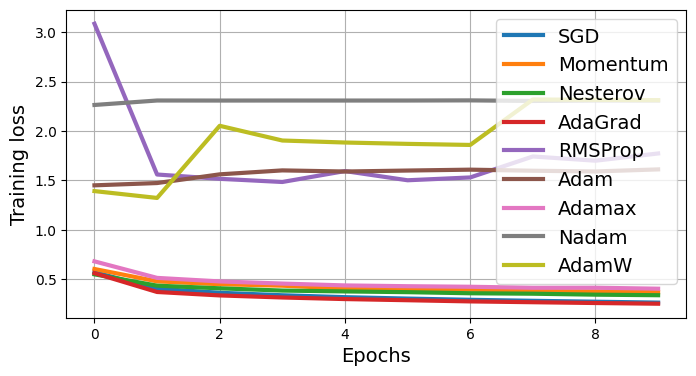

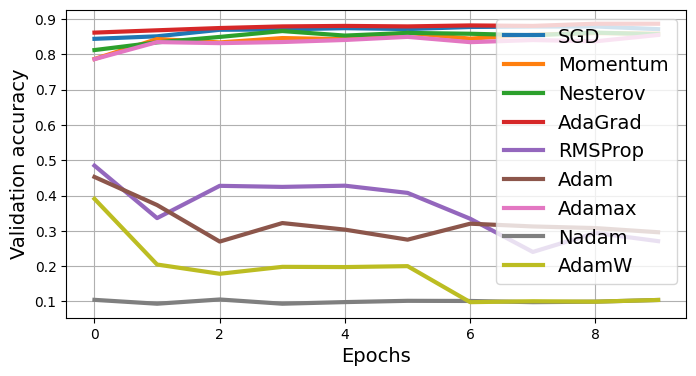

In [47]:
# extra code – visualize the learning curves of all the optimizers

for plot in ("train_losses", "valid_metrics"):
    plt.figure(figsize=(8, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip(
        (history_sgd, history_momentum, history_nesterov, history_adagrad,
         history_rmsprop, history_adam, history_adamax, history_nadam,
         history_adamw), opt_names.split()):
        plt.plot(history[plot], label=opt_name, linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"train_losses": "Training loss", "valid_metrics": "Validation accuracy"}[plot])
    plt.legend(loc="upper right")
    plt.show()

# Learning Rate Scheduling

Uma boa taxa de aprendizado é crucial: muito alta faz o treino divergir; muito baixa torna-o lento e sujeito a ótimos locais. Mesmo taxas “altas porém estáveis” avançam rápido no início, mas acabam oscilando perto do ótimo e rendem modelo subótimo; já uma taxa “perfeita” costuma deixar o treino devagar. Melhor que usar valor constante é **começar alto e reduzir depois**, permitindo rapidez inicial e refinamento no fim. Essas estratégias de ajuste dinâmico chamam-se **learning rate schedules**, e o `torch.optim.lr_scheduler` oferece várias, começando pela **exponential scheduling**.


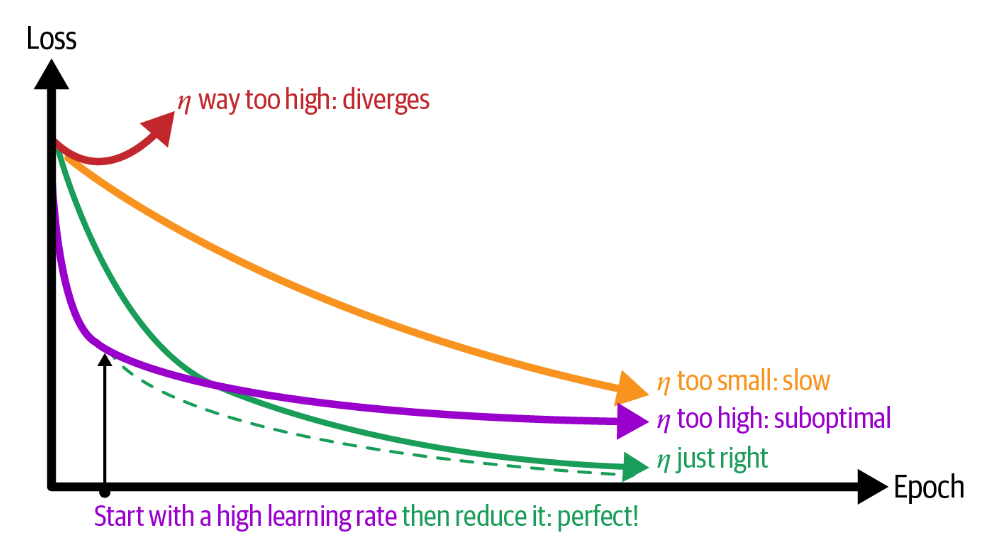

## Exponential Scheduling

O **ExponentialLR** multiplica a taxa de aprendizado por um fator constante $,\gamma,$ em intervalos regulares (geralmente a cada época). Assim, após $,n,$ épocas:

$$ \eta_n = \eta_0 \cdot \gamma^{,n} $$

Escolha $,\gamma < 1,$ e **próximo de 1** para não reduzir rápido demais (ex.: $,\gamma=0{,}9,$ → ~35% da taxa inicial em 10 épocas; ~12% em 20). O construtor exige ao menos o **otimizador** e o **fator $,\gamma$**.


In [48]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [49]:
def train_with_scheduler(model, optimizer, loss_fn, metric, train_loader,
                         valid_loader, n_epochs, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        losses = []
        metric.reset()
        for X_batch, y_batch in train_loader:
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_metric)
        else:
            scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_scheduler(model, optimizer, scheduler, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_scheduler(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [52]:
import numpy as np

history_exp, acc_exp = test_scheduler(model, optimizer, exp_scheduler)  # extra code

Epoch 1/10, train loss: 0.4015, train metric: 0.8534, valid metric: 0.8306
Learning rate: 0.04500
Epoch 2/10, train loss: 0.3569, train metric: 0.8685, valid metric: 0.8646
Learning rate: 0.04050
Epoch 3/10, train loss: 0.3294, train metric: 0.8791, valid metric: 0.8716
Learning rate: 0.03645
Epoch 4/10, train loss: 0.3098, train metric: 0.8847, valid metric: 0.8796
Learning rate: 0.03281
Epoch 5/10, train loss: 0.2944, train metric: 0.8901, valid metric: 0.8688
Learning rate: 0.02952
Epoch 6/10, train loss: 0.2800, train metric: 0.8959, valid metric: 0.8758
Learning rate: 0.02657
Epoch 7/10, train loss: 0.2685, train metric: 0.8999, valid metric: 0.8818
Learning rate: 0.02391
Epoch 8/10, train loss: 0.2572, train metric: 0.9047, valid metric: 0.8810
Learning rate: 0.02152
Epoch 9/10, train loss: 0.2490, train metric: 0.9076, valid metric: 0.8850
Learning rate: 0.01937
Epoch 10/10, train loss: 0.2399, train metric: 0.9119, valid metric: 0.8862
Learning rate: 0.01743


In [53]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)

In [54]:
history_perf, acc_perf = test_scheduler(model, optimizer, perf_scheduler)  # extra code

Epoch 1/10, train loss: 0.5710, train metric: 0.7930, valid metric: 0.8436
Learning rate: 0.05000
Epoch 2/10, train loss: 0.4024, train metric: 0.8530, valid metric: 0.8508
Learning rate: 0.05000
Epoch 3/10, train loss: 0.3620, train metric: 0.8669, valid metric: 0.8692
Learning rate: 0.05000
Epoch 4/10, train loss: 0.3366, train metric: 0.8762, valid metric: 0.8702
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3174, train metric: 0.8831, valid metric: 0.8738
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3030, train metric: 0.8870, valid metric: 0.8712
Learning rate: 0.05000
Epoch 7/10, train loss: 0.2906, train metric: 0.8913, valid metric: 0.8772
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2807, train metric: 0.8957, valid metric: 0.8784
Learning rate: 0.05000
Epoch 9/10, train loss: 0.2715, train metric: 0.8978, valid metric: 0.8786
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2622, train metric: 0.9016, valid metric: 0.8710
Learning rate: 0.05000


In [55]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, end_factor=1.0, total_iters=3)

In [56]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: (min(epoch, 3) / 3) * (1.0 - 0.1) + 0.1)

In [57]:
# extra code
def train_with_warmup(model, optimizer, loss_fn, metric, train_loader,
                      valid_loader, n_epochs, warmup_scheduler, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):

        warmup_scheduler.step()

        # extra code
        losses = []
        metric.reset()

        for X_batch, y_batch in train_loader:

            # extra code
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")

        if epoch >= 3:  # deactivate other scheduler(s) during warmup
            scheduler.step(val_metric)

        # extra code
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_warmup_scheduler(model, optimizer, warmup_scheduler, scheduler,
                          n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_warmup(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, warmup_scheduler, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [58]:
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)
test_warmup_scheduler(model, optimizer, warmup_scheduler, perf_scheduler,
                      n_epochs=10, batch_size=32)

Epoch 1/10, train loss: 0.6286, train metric: 0.7788, valid metric: 0.8356
Learning rate: 0.00500
Epoch 2/10, train loss: 0.4498, train metric: 0.8395, valid metric: 0.8394
Learning rate: 0.00500
Epoch 3/10, train loss: 0.4023, train metric: 0.8541, valid metric: 0.8656
Learning rate: 0.00500
Epoch 4/10, train loss: 0.3603, train metric: 0.8681, valid metric: 0.8708
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3350, train metric: 0.8771, valid metric: 0.8734
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3159, train metric: 0.8829, valid metric: 0.8694
Learning rate: 0.05000
Epoch 7/10, train loss: 0.3013, train metric: 0.8881, valid metric: 0.8768
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2892, train metric: 0.8914, valid metric: 0.8700
Learning rate: 0.05000
Epoch 9/10, train loss: 0.2794, train metric: 0.8972, valid metric: 0.8758
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2683, train metric: 0.8999, valid metric: 0.8730
Learning rate: 0.00500


({'train_losses': [np.float64(0.628603962564829),
   np.float64(0.44983716296067827),
   np.float64(0.40226908034193715),
   np.float64(0.36026787254883497),
   np.float64(0.33502112600763845),
   np.float64(0.3158586380473398),
   np.float64(0.3013238393468105),
   np.float64(0.28916015639823145),
   np.float64(0.2793934434249243),
   np.float64(0.26831843189075977)],
  'train_metrics': [0.7788363695144653,
   0.8395272493362427,
   0.8541272878646851,
   0.8681091070175171,
   0.8771272897720337,
   0.8828545212745667,
   0.8881454467773438,
   0.8914181590080261,
   0.8971818089485168,
   0.8998545408248901],
  'valid_metrics': [0.8356000185012817,
   0.8393999934196472,
   0.8655999898910522,
   0.8708000183105469,
   0.8733999729156494,
   0.8694000244140625,
   0.876800000667572,
   0.8700000047683716,
   0.8758000135421753,
   0.8730000257492065]},
 tensor(0.8653, device='cuda:0'))

## Cosine Annealing

Em vez de diminuir a taxa de aprendizado exponencialmente, você pode usar a função cosseno para ir da taxa de aprendizado máxima ηmax no início do treinamento até a taxa de aprendizado mínima ηmin no final. Isso é chamado de recozimento por cosseno. Comparado ao escalonamento exponencial, o recozimento por cosseno garante que a taxa de aprendizado permaneça relativamente alta durante a maior parte do treinamento, aproximando-se do mínimo próximo ao final (veja a Figura a seguir). No geral, o recozimento por cosseno costuma apresentar melhor desempenho. A taxa de aprendizado na época t (indexada a zero) é dada pela Equação abaixo, onde Tmax é o número máximo de épocas.

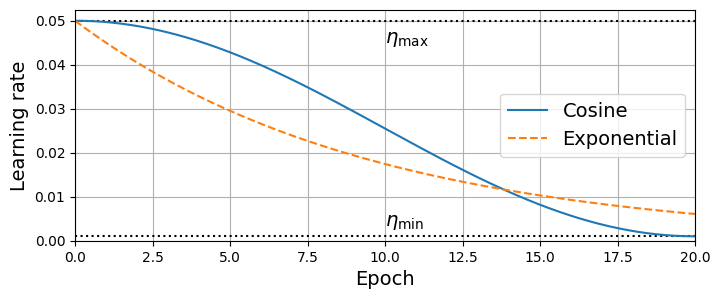

In [60]:
t = np.linspace(0, 20, 400)
eta_min = 0.001
eta_max = 0.05
t2 = 20
eta_cos_t = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(t / t2 * np.pi))
eta_exp_t = 0.9 ** t * eta_max

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 20, color="k", linestyle="dotted")
plt.plot(t, eta_cos_t, label="Cosine")
plt.plot(t, eta_exp_t, "--", label="Exponential")
plt.legend(loc="center right")
plt.text(10, eta_min + 0.0025, r"$\eta_\text{min}$")
plt.text(10, eta_max - 0.005, r"$\eta_\text{max}$")
plt.axis([0, 20, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.show()

A taxa de aprendizado no Cosine Annealing é calculada pela fórmula:

$$
\eta_t = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left( 1 + \cos \left( \frac{t}{T_{\text{max}}} \pi \right) \right)
$$

Onde:
- $\eta_t$ = taxa de aprendizado na época \(t\)
- $\eta_{\text{max}}$ = taxa máxima
- $\eta_{\text{min}}$ = taxa mínima
- $T_{\text{max}}$ = número máximo de épocas





Um problema com o recozimento de cosseno é que você precisa definir dois novos hiperparâmetros, Tmax e ηmin, e não é fácil saber de antemão quantas épocas de treinamento usar e quando parar de diminuir a taxa de aprendizado. É por isso que geralmente prefiro usar a técnica de agendamento de desempenho.

## Performance Scheduling

O **Performance Scheduling**, também conhecido como **agendamento adaptativo**, é implementado no PyTorch através do *scheduler*  
`torch.optim.lr_scheduler.ReduceLROnPlateau`.


###  Ideia Principal

Esse agendador **monitora uma métrica durante o treinamento** — normalmente a **perda de validação (validation loss)**.  
Se essa métrica **parar de melhorar** por um certo tempo, o *scheduler* **reduz a taxa de aprendizado**, multiplicando-a por um fator constante.

Essa estratégia é útil para:
- Evitar que o modelo fique preso em platôs do gradiente;  
- Reduzir o *learning rate* automaticamente quando a melhora desacelera;  
- Controlar o progresso do treinamento de forma **adaptativa** e **automática**.

###  Principais Hiperparâmetros

O `ReduceLROnPlateau` possui diversos parâmetros, mas os principais a ajustar são:

#### **1. `mode`**
- Define **se a métrica monitorada deve ser minimizada ou maximizada**.
- Valores possíveis:
  - `'min'` → para métricas como *validation loss* (**padrão**).
  - `'max'` → para métricas como *validation accuracy*.

#### **2. `patience`**
- Número de **épocas consecutivas sem melhora** na métrica antes de reduzir a taxa de aprendizado.
- Padrão: `10`.
- Se cada época for muito longa, reduza esse valor.

#### **3. `factor`**
- Fator pelo qual o *learning rate* é multiplicado quando não há melhora.
- Padrão: `0.1`.
- Em alguns casos, esse valor pode ser pequeno demais; por exemplo, `0.5` pode funcionar melhor.


###  Exemplo de Implementação

A seguir, implementamos o *Performance Scheduling* com base na **acurácia de validação** (que deve ser **maximizada**):

```python
# [...]  # construir o modelo e o otimizador
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",     # queremos maximizar a métrica (ex: acurácia)
    patience=2,     # reduz o LR após 2 épocas sem melhora
    factor=0.1      # multiplica o LR por 0.1 quando não há melhora
)


Durante o treinamento, precisamos ajustar o **loop de treino** para avaliar a métrica desejada ao final de cada época  
(e.g., **acurácia de validação** usando a função `evaluate_tm()` definida no Capítulo 10).  
Em seguida, passamos o resultado dessa métrica para o método `scheduler.step()`.

```python
for epoch in range(n_epochs):
    for X_batch, y_batch in train_loader:
        [...]  # restante do loop de treinamento permanece o mesmo

    val_acc = evaluate_tm(model, val_loader)  # avalia a métrica de validação
    scheduler.step(val_acc)                   # atualiza a taxa de aprendizado com base na métrica


## Warming Up the Learning Rate

Até agora, sempre iniciamos o treinamento com a **taxa de aprendizado máxima**.  
No entanto, isso pode fazer com que o gradiente **oscile aleatoriamente** no início do treinamento — sem explodir, mas também sem fazer progresso significativo.  
Esse comportamento é comum em **modelos sensíveis**, como **redes neurais recorrentes (RNNs)**, ou quando usamos **lotes (batch size) muito grandes**.

Em tais casos, uma solução eficaz é o **“aquecimento” (warm-up)** da taxa de aprendizado — começando com um valor **próximo de zero** e **aumentando gradualmente** durante as primeiras épocas, até atingir o valor máximo.  
Durante essa fase de aquecimento, o gradiente descendente tem tempo para **se estabilizar** em uma região mais adequada da paisagem da função de perda, permitindo um progresso mais rápido nas etapas seguintes.

## **Por que o warm-up funciona?**

A paisagem da função de perda pode se parecer com os **Himalaias**: alta e cheia de picos afiados.  
Se começarmos com uma taxa de aprendizado muito alta, o otimizador pode **pular de um pico para outro**, demorando muito para encontrar o vale.  
Com uma taxa pequena no início, o algoritmo **desce suavemente os vales** e **escapa das regiões mais íngremes**, alcançando áreas mais planas — onde pode, então, **usar uma taxa de aprendizado maior** de forma mais estável.


## **Implementando o warm-up com PyTorch**

Uma maneira comum de implementar o **warm-up da taxa de aprendizado** é usando o agendador `LinearLR`, que **aumenta linearmente** a taxa de aprendizado ao longo de algumas épocas.

Por exemplo, o código abaixo aumenta a taxa de aprendizado de **10% até 100%** do valor original do otimizador em **3 épocas**  
(ou seja, 10% na primeira, 40% na segunda, 70% na terceira e 100% depois disso):

```python
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, end_factor=1.0, total_iters=3)

 **Criando uma Função Personalizada com `LambdaLR`**

Se você quiser mais **flexibilidade**, pode criar sua própria função personalizada e encapsulá-la em um agendador `LambdaLR`.

Por exemplo, o código abaixo é **equivalente** ao `LinearLR` que acabamos de definir:

```python
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: (min(epoch, 3) / 3) * (1.0 - 0.1) + 0.1
)

# **Atualizando o Loop de Treinamento**

Você deve inserir o comando `warmup_scheduler.step()` **no início de cada época**  
e garantir que **outros agendadores de taxa de aprendizado fiquem desativados** durante a fase de *warm-up*.

```python
for epoch in range(n_epochs):
    warmup_scheduler.step()
    for X_batch, y_batch in train_loader:
        [...]  # restante do loop de treinamento permanece o mesmo
    if epoch >= 3:  # desativa outros agendadores durante o aquecimento
        scheduler.step(val_metric)

## Cosine Annealing with Warm Restarts

In [64]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=20, eta_min=0.001)

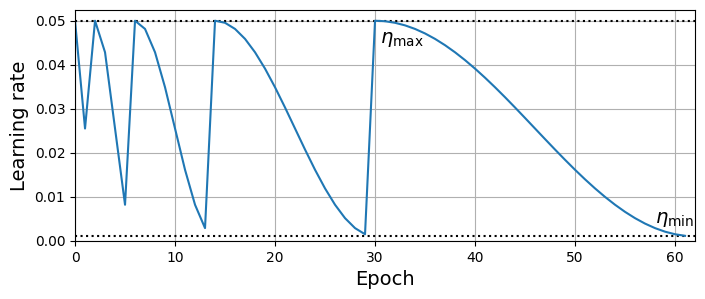

In [65]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_repeat_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=2, T_mult=2, eta_min=0.001)

lrs = []
for epoch in range(62):
    lrs.append(cosine_repeat_scheduler.get_last_lr()[0])
    cosine_repeat_scheduler.step()

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 64, color="k", linestyle="dotted")
plt.plot(lrs, label="Cosine")
plt.text(30.5, eta_max - 0.005, r"$\eta_\text{max}$")
plt.text(58, eta_min + 0.003, r"$\eta_\text{min}$")
plt.axis([0, 62, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.show()

In [1]:
import re

DOCS_URL = "https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler"
for name in sorted(dir(torch.optim.lr_scheduler)):
    scheduler = getattr(torch.optim.lr_scheduler, name)
    if (not name.startswith("_") and isinstance(scheduler, type) and
        issubclass(scheduler, torch.optim.lr_scheduler.LRScheduler)):
            print(f"• {DOCS_URL}.{name}.html")

NameError: name 'torch' is not defined